# Clustering via Evolution of the Heat Equation

Clustering with the heat equation uses low eigenvectors of a graph Laplacian as indicator functions to extract clusters from a graph. These eigenvectors are analogous to low frequency Fourier modes and by selecting these modes we seek the Fourier basis functions of the discrete domain induced by the graph. 

Description of the experiment:
1. Create a circle graph with $n=100$ nodes
2. At the end nodes and middle nodes, set an edge weight to $0.001$
3. Initialize a random initial condition by sampling uniformly from $[0, 1]$.
4. Update the heat using forward Euler method for $T_{\text{max}} = 10000$ iterations
5. At each time $t'$, compute the *centered normalized* heat: $ \frac{u(t', n) - \texttt{AVG}[u(t', \bullet)]}{\|u(t', n) - \texttt{AVG}[u(t', \bullet)]\|}$

Hypothesis: the centered normalized heat converges to the second Eigenvector of the (symmetric) graph laplacian. 

Why? The function $u(t', n)$ is a superposition of eigenvectors whose coefficients decay exponentially in time. Subtracting the mean removes the first eigenvector so that the second should dominate the mixture.

*The experiments validate this hypothesis*


**Extracting Eigenvectors Using the Heat Equation**

We show that evolving a system using the heat equation, then projecting the solution onto the orthogonal complement of the first few eigenvectors, yields a good approximation of the next highest eigenvector.

**Generate a line graph**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import gif
from lib.spectral_clustering import laplacian_matrix

# parameters
n = 100
dx = 1/n
dt = 0.01 * (1/2) * (dx**2) # Using CFL Conditions
T_max = 1000000

line_graph_similarity = np.diag(np.ones(n-1), k=1) + np.diag(np.ones(n-1), k=-1)

h = int(np.floor(n/2))
bad_edge_weight = 0
#line_graph_similarity[h, h+1] = bad_edge_weight
#line_graph_similarity[h+1, h] = bad_edge_weight
line_graph_similarity[0, -1] = bad_edge_weight
line_graph_similarity[-1, 0] = bad_edge_weight

laplacian, deg = laplacian_matrix(line_graph_similarity)



**Randomly initialize a function on the graph and step it in time**

In [14]:
evolution = np.zeros((n, T_max))

evolution[:, 0] = np.random.uniform(size=(n,)) + np.sin(0.05 * np.arange(n))

for i in range(1, T_max):
    evolution[:, i:i+1] = evolution[:, i-1:i] - (dt / (dx)**2) * laplacian @ evolution[:, i-1:i]

In [15]:
@gif.frame
def plot_evec(i):
    sig = evolution[:, i] - np.mean(evolution[:, i])
    sig /= np.linalg.norm(sig)
    plt.plot(sig)
    plt.title("Centered Heat Diffusion on Disconnected Line Graph")
    plt.xlabel("Node")
    plt.ylabel("Heat")
    plt.ylim((-0.5, 0.5))
@gif.frame
def plot_time(i):
    sig = evolution[:, i]
    sig /= np.linalg.norm(sig)
    plt.plot(sig)
    plt.title("Heat Diffusion on Line Graph")
    plt.xlabel("Node")
    plt.ylabel("Heat")
    plt.ylim((-1, 2))
frames_noscale = []

b = 2
for i in np.logspace(np.log10(1)/np.log10(b), np.log10(T_max)/np.log10(b), base=b):
    if(i < T_max):
        frames_noscale.append(plot_time(int(i)))
gif.save(frames_noscale, "Diffusion_L_0.001_c.gif", duration=100)

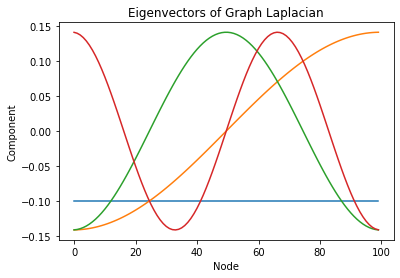

In [16]:
evals, evecs = np.linalg.eigh(laplacian)
plt.title("Eigenvectors of Graph Laplacian")
plt.xlabel("Node")
plt.ylabel("Component")
plt.plot(evecs[:, :4])
plt.show()

In [17]:
@gif.frame
def superplot(i, num_evecs, evolution, true_evecs, cumulative_energies):
    r, c = 3, num_evecs
    n, T = evolution.shape
    evolution_of_evecs = true_evecs.T @ evolution
    fig, ax = plt.subplots(r, c)
    for j in range(c):
        ax[0, j].plot(true_evecs[:, j])
        ax[0, j].set_ylim((-0.5, 0.5))
        ax[0, j].set_title("$\\vec{\\lambda}_"+str(j)+"$")
        high_freqs = true_evecs[:, j:] @ evolution_of_evecs[j:, i:i+1]
        high_freqs = high_freqs / np.linalg.norm(high_freqs)
        ax[1, j].set_ylim((-0.5, 0.5))
        ax[1, j].plot(high_freqs)
        ax[1, j].set_title(f"Frequencies above {j}")
        energy = cumulative_energies[j, :i]
        ax[2, j].plot(energy)
        ax[2, j].set_xscale("log", basex=2)
        ax[2, j].set_xlim((1, T))
        ax[2, j].set_ylim((0, 50))
    fig.set_size_inches(15, 7)
    plt.tight_layout()
    

_, true_evecs = np.linalg.eigh(laplacian)
evolution_of_evecs = true_evecs.T @ evolution
cumulative_energies = np.cumsum((evolution_of_evecs[::-1, :])**2, axis=0)[::-1, :]

frames = []
b = 2
frame_idxs = np.sort( np.concatenate( (np.logspace(np.log10(1)/np.log10(b), np.log10(T_max)/np.log10(b), base=b), T_max - np.arange(20))))

for i in frame_idxs:
    if(i < T_max):
        frames.append(superplot(int(i), 5, evolution, true_evecs, cumulative_energies))
gif.save(frames, "Eigenvector_Evolution.gif", duration=100)

/Users/maxdaniels/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


In [18]:
gif.save(frames, "Eigenvector_Evolution.gif", duration=100)